<a href="https://colab.research.google.com/github/Patrickbro13/Sporty-assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import cv2  
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision 
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

# Intializations

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
input_dim = 3
input_size = input_dim*32*32
hidden_size = 300
num_classes = 10
batch_size = 32
num_epochs = 50 
learning_rate = 1e-4
transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)) 
])

# Loading training and testing data

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms)
trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

Files already downloaded and verified


In [5]:
testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transforms)
testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

Files already downloaded and verified


In [6]:
len(trainset), len(testset)

(50000, 10000)

In [7]:
class_to_id = testset.class_to_idx 
class_to_id

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
testset.class_to_idx == trainset.class_to_idx

True

# Visualizing some data 

In [9]:
def show(imgs):
    plt.figure(figsize=(24,8))
    npimg = imgs.numpy()
    npimg = npimg*0.5 + 0.5 
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.axis('off')

In [10]:
dataiter = iter(trainloader)
images, labels = dataiter.next() #1st batch

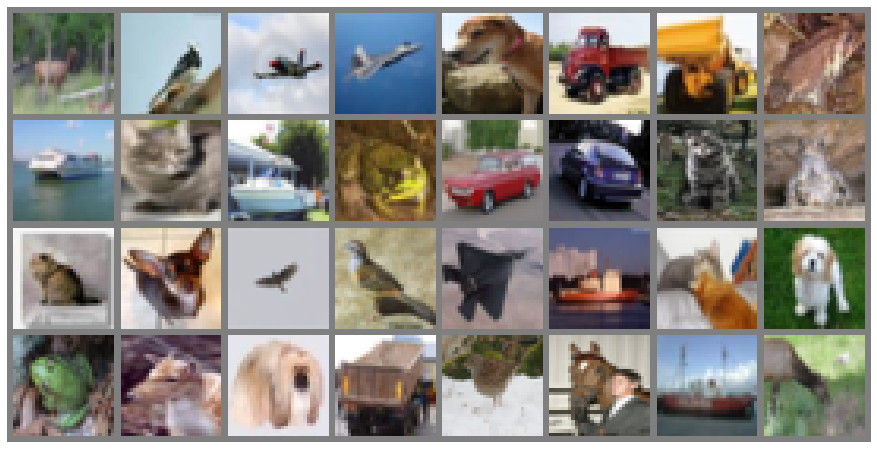

In [11]:
grid = make_grid(images)
show(grid)

# Models 

## NetA
The first neural network will be the simplest, in that it has no hidden layers. It should take the image
and flatten it to a vector for the input, and then have 10 outputs, one for each class.
There should be no non-linearities for this network and is just a very simple linear classifier

In [12]:
class NetA(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.input_size = input_size
        
        self.model = nn.Sequential(
            nn.Flatten(), #[32,3,32,32] to [32,3*32*32]
            nn.Linear(input_size, num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [13]:
netA = NetA(input_size, num_classes).to(device)

## NetB
The second neural network will be slightly more complicated in that it has a hidden layer with 300
nodes and adds a non-linearity between the layers. It should use the following operations in this order:

* Flatten the image to a vector for the input
* Use a fully-connected linear layer with 300 hidden-neurons
* Use the ReLU activation function
* Use a fully-connected linear layer to the 10 outputs

In [14]:
class NetB(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.input_size = input_size
        self.model = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [15]:
netB = NetB(input_size, hidden_size, num_classes).to(device)

## NetC
This third neural network will be a convolutional neural network. It should use the following
operations in this order:

* Use a convolution layer with kernel-width 5 and depth 25
* Use the ReLU activation function
* Use a max-pool operation with kernel-width 2 and stride 2
* Flatten the image to a vector for the next step's input
* Use a fully-connected linear layer to the 10 outputs.

In [16]:
class NetC(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.input_size = input_size
        self.model = nn.Sequential(
            nn.Conv2d(input_dim, 25, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(), 
            nn.Linear(4900, num_classes)
        )
    def forward(self, x):
        return self.model(x)

In [17]:
netC = NetC(input_dim, num_classes).to(device)

## function to train model

In [18]:
def train(model, num_epochs=num_epochs, learning_rate=learning_rate, trainloader=trainloader, testloader=testloader, device=device):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  
    criterion = nn.CrossEntropyLoss()

    train_accuracy = []
    test_accuracy = []
    for epoch in range(num_epochs):
        n_correct = 0
        n_samples = 0
        for images, labels in trainloader :
            # feed forward or forward pass 
            images = images.to(device)
            labels = labels.to(device)
            batch_output = model(images)

            # loss calculation
            loss = criterion(batch_output, labels)

            # Backward pass
            optimizer.zero_grad() # clear previous gradients
            loss.backward()
            optimizer.step()

            with torch.no_grad() :
                _, predicted = torch.max(batch_output.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item() 


        train_acc = n_correct / n_samples
        train_accuracy.append(train_acc)
        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)  
                outputs = model(images)

                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()
        
        test_acc = n_correct / n_samples
        test_accuracy.append(test_acc)
        print(f"Epoch {epoch+1}/{num_epochs} :\n\t Loss : {loss :.4f}    Accuracy {train_acc:.4f}    val_accuracy {test_acc:.4f}")
    history = {
        'model' : model.__class__.__name__,
        'epochs' : [i+1 for i in range(num_epochs)],
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }
    return history

# Training and Evalution

## NetA

In [19]:
historyA = train(netA)

Epoch 1/50 :
	 Loss : 1.6779    Accuracy 0.3618    val_accuracy 0.3886
Epoch 2/50 :
	 Loss : 1.9113    Accuracy 0.3999    val_accuracy 0.3993
Epoch 3/50 :
	 Loss : 1.4991    Accuracy 0.4082    val_accuracy 0.4022
Epoch 4/50 :
	 Loss : 1.5796    Accuracy 0.4158    val_accuracy 0.4044
Epoch 5/50 :
	 Loss : 1.6604    Accuracy 0.4191    val_accuracy 0.4072
Epoch 6/50 :
	 Loss : 1.2306    Accuracy 0.4219    val_accuracy 0.4074
Epoch 7/50 :
	 Loss : 2.0228    Accuracy 0.4252    val_accuracy 0.4102
Epoch 8/50 :
	 Loss : 1.9140    Accuracy 0.4283    val_accuracy 0.4059
Epoch 9/50 :
	 Loss : 1.8035    Accuracy 0.4310    val_accuracy 0.4049
Epoch 10/50 :
	 Loss : 2.0159    Accuracy 0.4315    val_accuracy 0.4075
Epoch 11/50 :
	 Loss : 1.2159    Accuracy 0.4347    val_accuracy 0.4095
Epoch 12/50 :
	 Loss : 2.2898    Accuracy 0.4358    val_accuracy 0.4118
Epoch 13/50 :
	 Loss : 2.1894    Accuracy 0.4365    val_accuracy 0.4035
Epoch 14/50 :
	 Loss : 1.8128    Accuracy 0.4369    val_accuracy 0.4127
E

## NetB

In [20]:
historyB = train(netB)

Epoch 1/50 :
	 Loss : 1.3581    Accuracy 0.4172    val_accuracy 0.4656
Epoch 2/50 :
	 Loss : 1.6307    Accuracy 0.4847    val_accuracy 0.4815
Epoch 3/50 :
	 Loss : 1.5476    Accuracy 0.5184    val_accuracy 0.5007
Epoch 4/50 :
	 Loss : 1.4269    Accuracy 0.5397    val_accuracy 0.5055
Epoch 5/50 :
	 Loss : 1.2572    Accuracy 0.5563    val_accuracy 0.5081
Epoch 6/50 :
	 Loss : 1.1291    Accuracy 0.5737    val_accuracy 0.5170
Epoch 7/50 :
	 Loss : 1.2807    Accuracy 0.5894    val_accuracy 0.5249
Epoch 8/50 :
	 Loss : 0.8653    Accuracy 0.6014    val_accuracy 0.5295
Epoch 9/50 :
	 Loss : 0.7857    Accuracy 0.6147    val_accuracy 0.5284
Epoch 10/50 :
	 Loss : 1.0729    Accuracy 0.6293    val_accuracy 0.5320
Epoch 11/50 :
	 Loss : 1.0884    Accuracy 0.6374    val_accuracy 0.5300
Epoch 12/50 :
	 Loss : 1.1700    Accuracy 0.6486    val_accuracy 0.5367
Epoch 13/50 :
	 Loss : 0.4963    Accuracy 0.6611    val_accuracy 0.5352
Epoch 14/50 :
	 Loss : 0.7066    Accuracy 0.6693    val_accuracy 0.5326
E

## NetC

In [21]:
historyC = train(netC)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/50 :
	 Loss : 1.3987    Accuracy 0.4168    val_accuracy 0.4941
Epoch 2/50 :
	 Loss : 0.9862    Accuracy 0.5163    val_accuracy 0.5292
Epoch 3/50 :
	 Loss : 1.2743    Accuracy 0.5480    val_accuracy 0.5492
Epoch 4/50 :
	 Loss : 1.0327    Accuracy 0.5645    val_accuracy 0.5607
Epoch 5/50 :
	 Loss : 1.3608    Accuracy 0.5782    val_accuracy 0.5645
Epoch 6/50 :
	 Loss : 1.3989    Accuracy 0.5918    val_accuracy 0.5812
Epoch 7/50 :
	 Loss : 1.4380    Accuracy 0.6024    val_accuracy 0.5843
Epoch 8/50 :
	 Loss : 1.1390    Accuracy 0.6108    val_accuracy 0.5902
Epoch 9/50 :
	 Loss : 1.3991    Accuracy 0.6209    val_accuracy 0.5937
Epoch 10/50 :
	 Loss : 1.1917    Accuracy 0.6309    val_accuracy 0.6047
Epoch 11/50 :
	 Loss : 1.0129    Accuracy 0.6371    val_accuracy 0.6071
Epoch 12/50 :
	 Loss : 1.3783    Accuracy 0.6459    val_accuracy 0.6102
Epoch 13/50 :
	 Loss : 1.3150    Accuracy 0.6500    val_accuracy 0.6172
Epoch 14/50 :
	 Loss : 0.6644    Accuracy 0.6555    val_accuracy 0.6212
E

# Summary 

In [22]:
histories = [historyA, historyB, historyC]

In [35]:
def summary(histories=histories):
    print('--'*30)
    final_train_acc = [history['train_accuracy'][-1] for history in histories]
    final_val_acc = [history['test_accuracy'][-1] for history in histories]
    models = [history['model'] for history in histories]
    df = pd.DataFrame(list(zip(final_train_acc, final_val_acc)), index= models, columns=['train accuracy', 'test_accuracy'])
    print(df.head())
    print('--'*30)
    epochs = histories[0]['epochs']
    for i in range(3):
        plt.figure(figsize=(10,5))
        plt.subplot(3,1,i+1)
        plt.plot(epochs, histories[i]['train_accuracy'], color='r', label='train_accuracy')
        plt.plot(epochs, histories[i]['test_accuracy'], color='b', label='test_accuracy')
        plt.title(models[i])
        plt.xlabel("epochs")
        plt.ylabel("accuracy")
        plt.legend()
        plt.show()


------------------------------------------------------------
      train accuracy  test_accuracy
NetA         0.45254         0.3981
NetB         0.89850         0.5234
NetC         0.73814         0.6415
------------------------------------------------------------


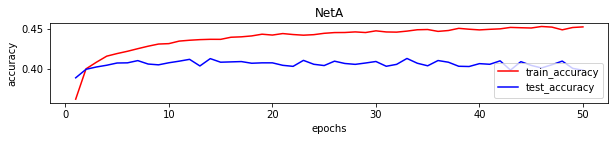

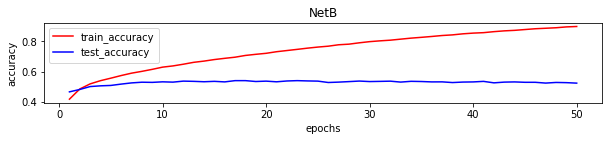

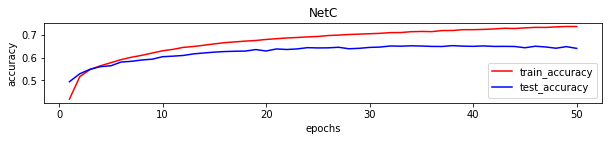

In [36]:
summary()